In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import os

# preprocess.py contains the function to load and preprocess the ice velocity data
from real_preprocess import load_and_preprocess_ice_velocity_data, combine_thickness_and_velocity, df_to_tensor

# Toggle on if you wish to overwrite the tensors in the data directory
OVERWRITE_TENSORS_BOOL = True

# Load data sets

In [2]:
### ICE THICKNESS DATA ###
# Bedmap 1 + 2 + 3 
# TODO: Change this to the full path that you used to download and proprocess the raw data in.
path_to_bedmap_data_folder = "/home/kim/data/bedmap_raw_data"
path_bedmap123_byrd = os.path.join(path_to_bedmap_data_folder, "bedmap123_byrd_catchment.csv")
thickness_points = pd.read_csv(path_bedmap123_byrd)

### ICE VELOCITY DATA ###
# NSIDC MEaSUREs Antarctic Ice Velocity Map
# NOTE: The coordinates in load_and_preprocess_ice_velocity_data() need to be large enough to not produce NaN in the interpolation
# TODO: Change
ice_vel_file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
# Function to load and preprocess the ice velocity data as xarray
velocity_grid = load_and_preprocess_ice_velocity_data(ice_vel_file_path)

# Check
print(f"Check number of rows Nan thickness:", thickness_points["t"].isna().sum())
print(f"Check number of rows Nan velocity:", np.isnan(velocity_grid.VX.values).sum())

Check number of rows Nan thickness: 0
Check number of rows Nan velocity: 0


## Load meta data for all of Antarctica (incl. firn correction notes)

In [3]:
meta = pd.read_csv("/home/kim/data/bedmap_raw_data_test/bedmap123_metadata.csv")

print(meta.BM_version.value_counts())
print()
print(meta.platform.value_counts())
print()
print(meta.firn.value_counts())

BM_version
BM3    84
BM2    66
BM1     1
Name: count, dtype: int64

platform
airborne radar.                        114
ground-based radar.                     33
seismic.                                 3
airborne radar, gravity and seismic      1
Name: count, dtype: int64

firn
0 (m)        92
10 (m)       28
-9999 (m)    25
4.7 (m)       1
5 (m)         1
8.8 (m)       1
2 (m)         1
6.5 (m)       1
8 (m)         1
Name: count, dtype: int64


# Firn adjustments

In [4]:
# Extract float
meta["firn_correction"] = meta.firn.str.extract(r"([-+]?\d*\.?\d+)").astype(float)
# Replace -9999 with 0.0 (We assume this means "zero" adjustment applied so far.)
meta["firn_correction"] = meta["firn_correction"].replace(-9999, 0.0)
# Calculate remaining delta (we correct all data to have a firn correction of 10)
# t_corrected = t_observed - 10

UNIVERSAL_FIRN_CORRECTION = 10.0
meta["firn_correction_delta"] = meta["firn_correction"] - UNIVERSAL_FIRN_CORRECTION

# Create lookup dictionary from meta
firn_delta_lookup = dict(zip(meta["source"], meta["firn_correction_delta"]))

# Add the correction delta to the thickness points
# NOTE: Overwrite
thickness_points["t"] = (
    thickness_points["t"] + thickness_points["source"].map(firn_delta_lookup)
)

In [5]:
# drop very old data
thickness_points = thickness_points[thickness_points["source"] != "BEDMAP1_1966-2000_AIR_BM1.csv"]

## Get overview of ice thickness data

# Define regions for experiments

In [6]:
# Define region
region = {
    "x_min": 400_000,
    "x_max": 600_000,
    "y_min": -950_000,
    "y_max": -750_000,
}

# Train border all around to ensure we are interpolating
border_width = 10_000
cell_size = 15_000
n_cells = 12

# Compute inner region (without border)
x0 = region["x_min"] + border_width
x1 = region["x_max"] - border_width
y0 = region["y_min"] + border_width
y1 = region["y_max"] - border_width

# Store train/test rectangles
data = []

### OUTER BORDER ###
# Add 4 border rectangles as "train" cells
# Top
data.append({
    "x": region["x_min"],
    "y": y1,
    "width": region["x_max"] - region["x_min"],
    "height": region["y_max"] - y1,
    "split": "train"
})
# Bottom
data.append({
    "x": region["x_min"],
    "y": region["y_min"],
    "width": region["x_max"] - region["x_min"],
    "height": y0 - region["y_min"],
    "split": "train"
})
# Left
data.append({
    "x": region["x_min"],
    "y": y0,
    "width": x0 - region["x_min"],
    "height": y1 - y0,
    "split": "train"
})
# Right
data.append({
    "x": x1,
    "y": y0,
    "width": region["x_max"] - x1,
    "height": y1 - y0,
    "split": "train"
})

### INNER CHECKERBOARD ###
# Generate checkerboard blocks in the inner region
for i in range(n_cells):
    for j in range(n_cells):
        x = x0 + i * cell_size
        y = y0 + j * cell_size
        split = "test" if (i + j) % 2 == 0 else "train"
        data.append({
            "x": x,
            "y": y,
            "width": cell_size,
            "height": cell_size,
            "split": split
        })

# Create DataFrame
df = pd.DataFrame(data)

In [7]:
thickness_points_region = thickness_points[
    (thickness_points["x"] > region["x_min"]) &
    (thickness_points["x"] < region["x_max"]) &
    (thickness_points["y"] > region["y_min"]) &
    (thickness_points["y"] < region["y_max"])
]

thickness_points_region.shape
## ~500 k points

(492164, 9)

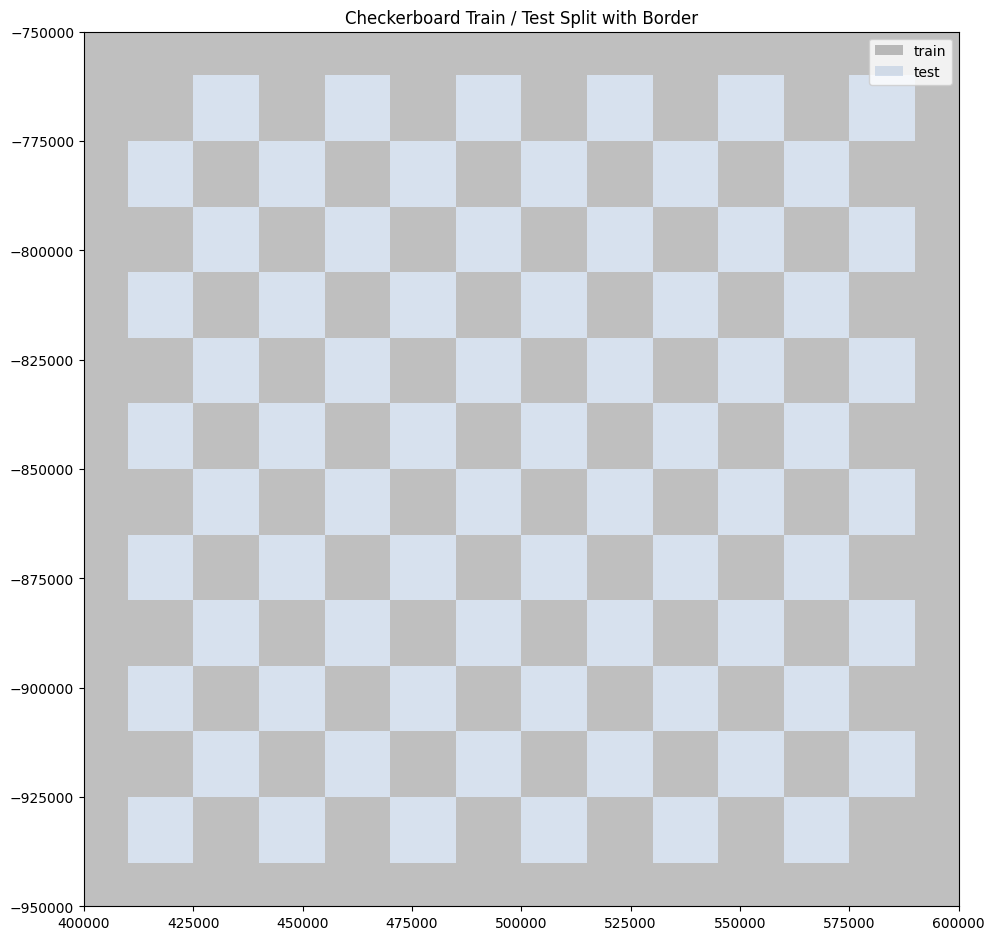

In [8]:
# Plot
fig, ax = plt.subplots(figsize = (10, 10))

train_color = "grey"
test_color = "lightsteelblue"

# Draw checkerboard and border (all in df now)
label_drawn = {"train": False, "test": False}
for _, row in df.iterrows():
    color = test_color if row.split == "test" else train_color
    label = row.split if not label_drawn[row.split] else None
    ax.add_patch(patches.Rectangle(
        (row.x, row.y), row.width, row.height,
        facecolor = color, edgecolor = "none", alpha = 0.5, label = label
    ))
    label_drawn[row.split] = True

# Annotate
ax.set_title("Checkerboard Train / Test Split with Border")
ax.set_xlim(region["x_min"], region["x_max"])
ax.set_ylim(region["y_min"], region["y_max"])
ax.set_aspect('equal')

# Deduplicate labels
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()

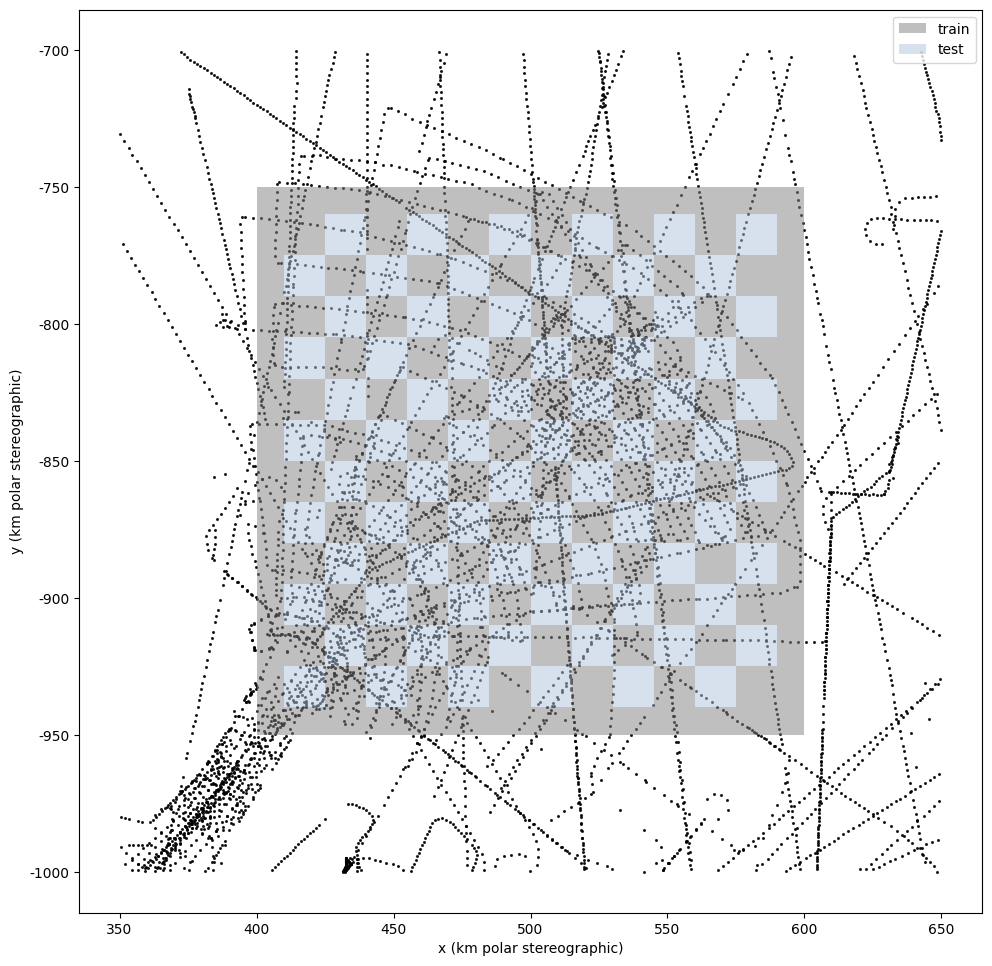

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import pandas as pd

# Your scatter plot data
reduce_rate = 100
thickness_points_ss = thickness_points[::reduce_rate]

fig, ax = plt.subplots(figsize = (10, 10))
sc = ax.scatter(thickness_points_ss['x'], thickness_points_ss['y'], 
                color = 'black', s = 1.5, alpha = 0.8)

# Format axes to scientific notation (km)
formatter = ticker.FuncFormatter(lambda x, pos: f'{x * 1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")
ax.set_aspect('equal')

# --- Checkerboard Overlay from df (includes border now) ---
label_drawn = {"train": False, "test": False}
for _, row in df.iterrows():
    color = test_color if row.split == "test" else train_color
    label = row.split if not label_drawn[row.split] else None
    ax.add_patch(patches.Rectangle(
        (row.x, row.y), row.width, row.height,
        facecolor = color, edgecolor = 'none', alpha = 0.5, label = label
    ))
    label_drawn[row.split] = True

# Legend (if desired)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc = "upper right", markerscale = 5)

# Colorbar for scatter (optional since scatter is black here)
# cbar = plt.colorbar(sc, ax = ax)
# cbar.set_label("Some value")

plt.tight_layout()
plt.show()

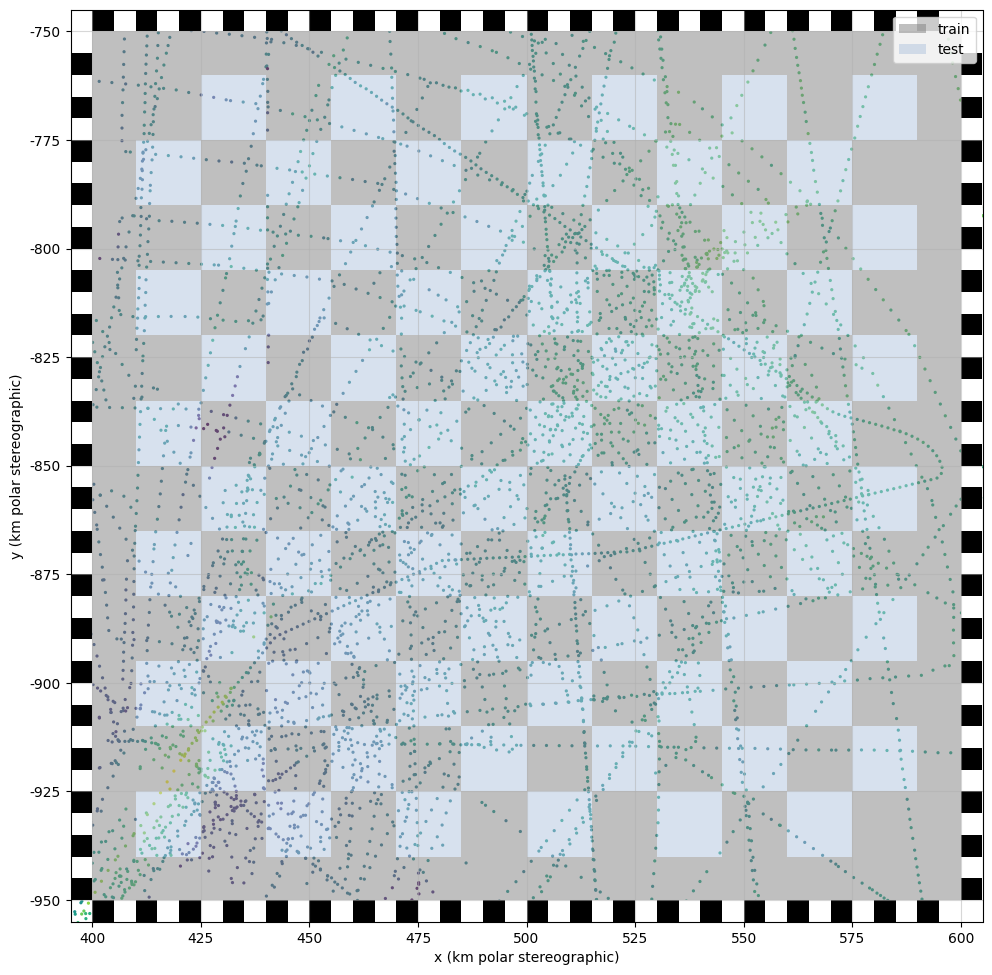

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import pandas as pd

# Subsample for plotting
reduce_rate = 100
thickness_points_ss = thickness_points[::reduce_rate]

# --- Plot ---
fig, ax = plt.subplots(figsize = (10, 10))

### ICE THICKNESS POINTS SCATTER ###
sc = ax.scatter(
    thickness_points_ss['x'], 
    thickness_points_ss['y'], 
    c = thickness_points_ss['t'], 
    s = 1.7, 
    alpha = 1.0, 
    cmap = 'viridis'
)

### CHECKERBOARD (INCLUDES BORDER) ###
global_alpha = 0.5
train_color = "grey"
test_color = "lightsteelblue"
global_edgecolor = "none"

label_drawn = {"train": False, "test": False}
for _, row in df.iterrows():
    color = test_color if row.split == "test" else train_color
    label = row.split if not label_drawn[row.split] else None
    ax.add_patch(patches.Rectangle(
        (row.x, row.y), row.width, row.height,
        facecolor = color, edgecolor = global_edgecolor, alpha = global_alpha, label = label
    ))
    label_drawn[row.split] = True

### TIC-TAC BORDER ###
tick_size = 5_000
for x in range(region["x_min"], region["x_max"], tick_size):
    color = "black" if (x // tick_size) % 2 == 0 else "white"
    ax.add_patch(patches.Rectangle((x, region["y_max"]), tick_size, tick_size, facecolor = color, edgecolor = "none"))
    ax.add_patch(patches.Rectangle((x, region["y_min"] - tick_size), tick_size, tick_size, facecolor = color, edgecolor = "none"))

for y in range(region["y_min"], region["y_max"], tick_size):
    color = "black" if (y // tick_size) % 2 == 0 else "white"
    ax.add_patch(patches.Rectangle((region["x_min"] - tick_size, y), tick_size, tick_size, facecolor = color, edgecolor = "none"))
    ax.add_patch(patches.Rectangle((region["x_max"], y), tick_size, tick_size, facecolor = color, edgecolor = "none"))

### AXIS SETUP ###
formatter = ticker.FuncFormatter(lambda x, pos: f'{x * 1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

# Limits & layout
ax.set_xlim(region["x_min"] - tick_size, region["x_max"] + tick_size)
ax.set_ylim(region["y_min"] - tick_size, region["y_max"] + tick_size)
ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)

# Legend & colorbar
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc = "upper right")

# cbar = plt.colorbar(sc, ax = ax)
# cbar.set_label("Thickness (m)")

plt.tight_layout()
plt.show()

# Split data

In [11]:
# Create lists to collect train and test points
train_points = []
test_points  = []

# Assign points based on all rectangles in df
for _, row in df.iterrows():
    mask = (
        (thickness_points["x"] >= row["x"]) &
        (thickness_points["x"] <  row["x"] + row["width"]) &
        (thickness_points["y"] >= row["y"]) &
        (thickness_points["y"] <  row["y"] + row["height"])
    )
    
    if row["split"] == "train":
        train_points.append(thickness_points[mask])
    elif row["split"] == "test":
        test_points.append(thickness_points[mask])

# Concatenate into final DataFrames
train_thickness_points_df = pd.concat(train_points, ignore_index = True)
test_thickness_points_df  = pd.concat(test_points,  ignore_index = True)

print(f"Train points: {len(train_thickness_points_df)}")
print(f"Test points: {len(test_thickness_points_df)}")

Train points: 271715
Test points: 220449


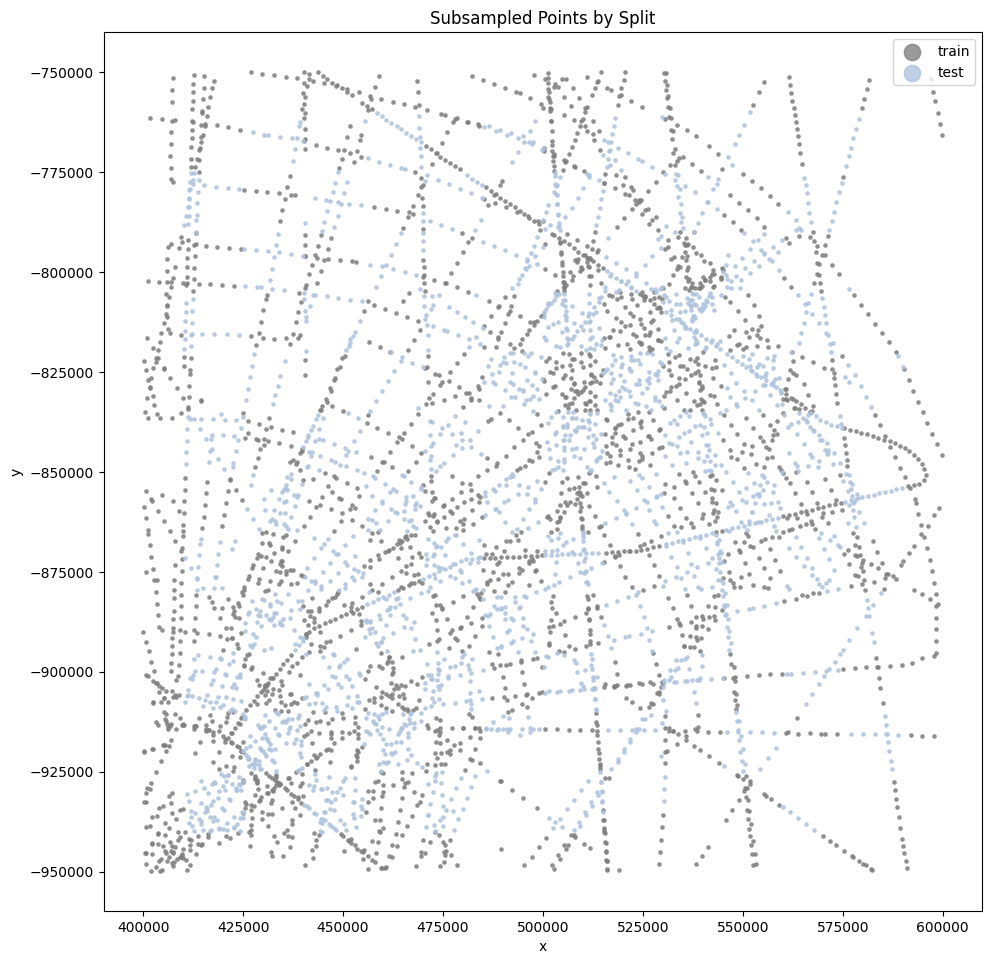

In [12]:
VIS_SUBSAMPLE_RATE = 100

fig, ax = plt.subplots(figsize = (10, 10))

# Plot train points
ax.scatter(train_thickness_points_df["x"][::VIS_SUBSAMPLE_RATE], train_thickness_points_df["y"][::VIS_SUBSAMPLE_RATE],
           s = 5.5, alpha = 0.8, color = train_color, label = "train")

# Plot test points
ax.scatter(test_thickness_points_df["x"][::VIS_SUBSAMPLE_RATE], test_thickness_points_df["y"][::VIS_SUBSAMPLE_RATE], 
           s = 5.5, alpha = 0.8, color = test_color, label = "test")

# Axes formatting
ax.set_title("Subsampled Points by Split")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(markerscale = 5)

plt.tight_layout()
plt.show()

## Process train

In [ ]:
chunck_size = 5_000

full_train_df = pd.DataFrame()

for i in range(0, len(train_thickness_points_df), chunck_size):
    chunk = train_thickness_points_df[i:i + chunck_size]
    # NOTE: preprocessing is suitable to NN models
    processed_chunk = combine_thickness_and_velocity(chunk, velocity_grid, subsample_rate = 1)
    full_train_df = pd.concat([full_train_df, processed_chunk], ignore_index = True)

Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled dat

In [ ]:
train_tensor = df_to_tensor(full_train_df, 
                            x_min = 400_000, x_max = 600_000,
                            y_min = -950_000, y_max = -750_000,
                            flux_scale = 70_000, vel_scale = 70, surface_scale = 2000)
if OVERWRITE_TENSORS_BOOL:
    torch.save(train_tensor, "data/train_test_tensors/train_tensor.pt")

## Repeat for test

In [74]:
full_test_df = pd.DataFrame()

for i in range(0, len(test_thickness_points_df), chunck_size):
    chunk = test_thickness_points_df[i:i + chunck_size]
    processed_chunk = combine_thickness_and_velocity(chunk, velocity_grid, subsample_rate = 1)
    full_test_df = pd.concat([full_test_df, processed_chunk], ignore_index = True)

Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled data shape: (5000, 13)
Subsampled dat

In [ ]:
test_tensor = df_to_tensor(full_test_df, 
                            x_min = 400_000, x_max = 600_000,
                            y_min = -950_000, y_max = -750_000,
                            flux_scale = 70_000, vel_scale = 70, surface_scale = 2000)

if OVERWRITE_TENSORS_BOOL:
    torch.save(test_tensor, "data/train_test_tensors/test_tensor.pt")